# scQUEST AML Tutorial

In this tutorial we show how to use and adapt scQUEST by testing it on a publicly available acute myeloid leukemia (AML) mass cytometry (CyTOF) dataset from ([Levine et al., 2015](https://doi.org/10.1016/j.cell.2015.05.047)). Specifically, we used the data illustrated in Figure 3 of (Levine et al., 2015) that are publicly available on Cytobank. In this dataset, bone marrow samples from healthy donors and pediatric AML patients were analyzed by CyTOF using a panel of 32 markers.

Although this tutorial follows the same workflow as the [standard scQUEST tutorial](https://github.com/AI4SCR/scQUEST/blob/master/tutorials/scQUEST_tutorial.ipynb), the AML dataset analyzed here is different in terms of cell populations present, number of proteins analyzed etc, which makes it ideal to illustrate how to adapt the standard scQUEST models to fit these needs.

## Import needed packages 

In [1]:
import scQUEST as scq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import preprocessing
import torch
import warnings
import anndata
from pathlib import Path

warnings.filterwarnings('ignore')

## Step 1: Load and explore CyTOF dataset 

As before, we provide the CyTOF data from Figure 3 of ([Levine et al., 2015](https://doi.org/10.1016/j.cell.2015.05.047)) in an already processed reference AnnData object that can be simply loaded as follows:

In [2]:
ad = scq.dataset.aml_annotated_celltypes()
ad

AnnData object with n_obs × n_vars = 96381 × 39
    obs: 'fcs_file', 'celltype', 'complexcelltype', 'patient', 'ncells'
    var: 'channel', 'marker', 'usedformanualannotation', 'usedforPhenoGraphclustering'
    uns: 'fcs_header'

We see that there are a total of 96,381 cells present that have been analyzed by CyTOF. Using 19 out of the CyTOF markers, the single-cell profiles originating from bone marrow samples of 2 healthy donors have been manually annotated via gating in 6 different cell types to determine cell types of interest, and these cell types were downloaded in separate .fcs files from Cytobank (cell type id found in `obs['celltype']`). These cell types have  different proportions, with T cells and Monocytes been more abundant and NK cells and Pre-B cells more rare.

In [3]:
print('Number of cells per cell type:\n' + str(ad.obs['celltype'].value_counts()))

Number of cells per cell type:
CD4Tcells    26366
Monocytes    21099
CD8Tcells    20108
Bcells       16520
NKcells       6153
PreBcells     6135
Name: celltype, dtype: int64


First, we pre-process the whole dataset and censor outliers:

In [4]:
# censor data to the 99.5% percentile
X = ad.X.copy()
quantiles = np.quantile(X, q=.995, axis=0)
for i, thres in zip(range(X.shape[1]), quantiles):
    X[X[:, i] > thres, i] = thres

# arcsinh-transform using a cofactor of 5
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)
ad.layers['arcsinh'] = X
ad

AnnData object with n_obs × n_vars = 96381 × 39
    obs: 'fcs_file', 'celltype', 'complexcelltype', 'patient', 'ncells'
    var: 'channel', 'marker', 'usedformanualannotation', 'usedforPhenoGraphclustering'
    uns: 'fcs_header'
    layers: 'arcsinh'

## Step 2: Cell type identification


Here we show how to use scQUEST to perform automatic cell type identification of these 6 different cell types using the single-cell measurements.
Let's prepare the dataset for classification by first selecting a list of 32 markers (same as the ones Levine et al. use for clustering), to train the classifier, and then scaling the data:

In [5]:
# define the markers used in the classifier
ad_anno = ad[:, ad.var.usedforPhenoGraphclustering == 'yes']
#scale the data:
scaler = StandardScaler()
X = scaler.fit_transform(ad_anno.layers['arcsinh'])
ad_anno.layers['arcsinh_norm'] = X

Before we train the classifier, let's visualize the data distribution per class. We can either select one marker and plot it across all cell types, or simply plot all marker distributions in a combination of cell types. 

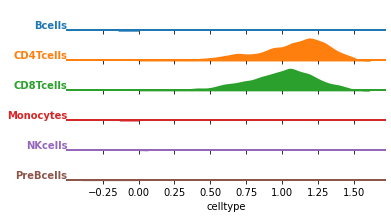

In [10]:
df = pd.DataFrame(data=ad_anno.layers['arcsinh_norm'], columns=ad_anno.var.marker)
df['celltype'] = ad.obs.celltype.values
df = df.groupby('celltype').sample(n=1000)
df = df.melt(id_vars='celltype')

# change the marker name to explore other markers
marker = 'CD3'
g = sns.FacetGrid(df[df.marker == marker], row="celltype", hue="celltype", aspect=10, height=.5)
g.map(sns.kdeplot, "value",
      bw_adjust=.5, clip_on=False, clip=(0, df.value.max()),
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=.5, clip=(0, df.value.max()))
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="right", va="center", transform=ax.transAxes)
g.map(label, "celltype")

# prevent the subplots from overlapping
g.figure.subplots_adjust(hspace=+0.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()

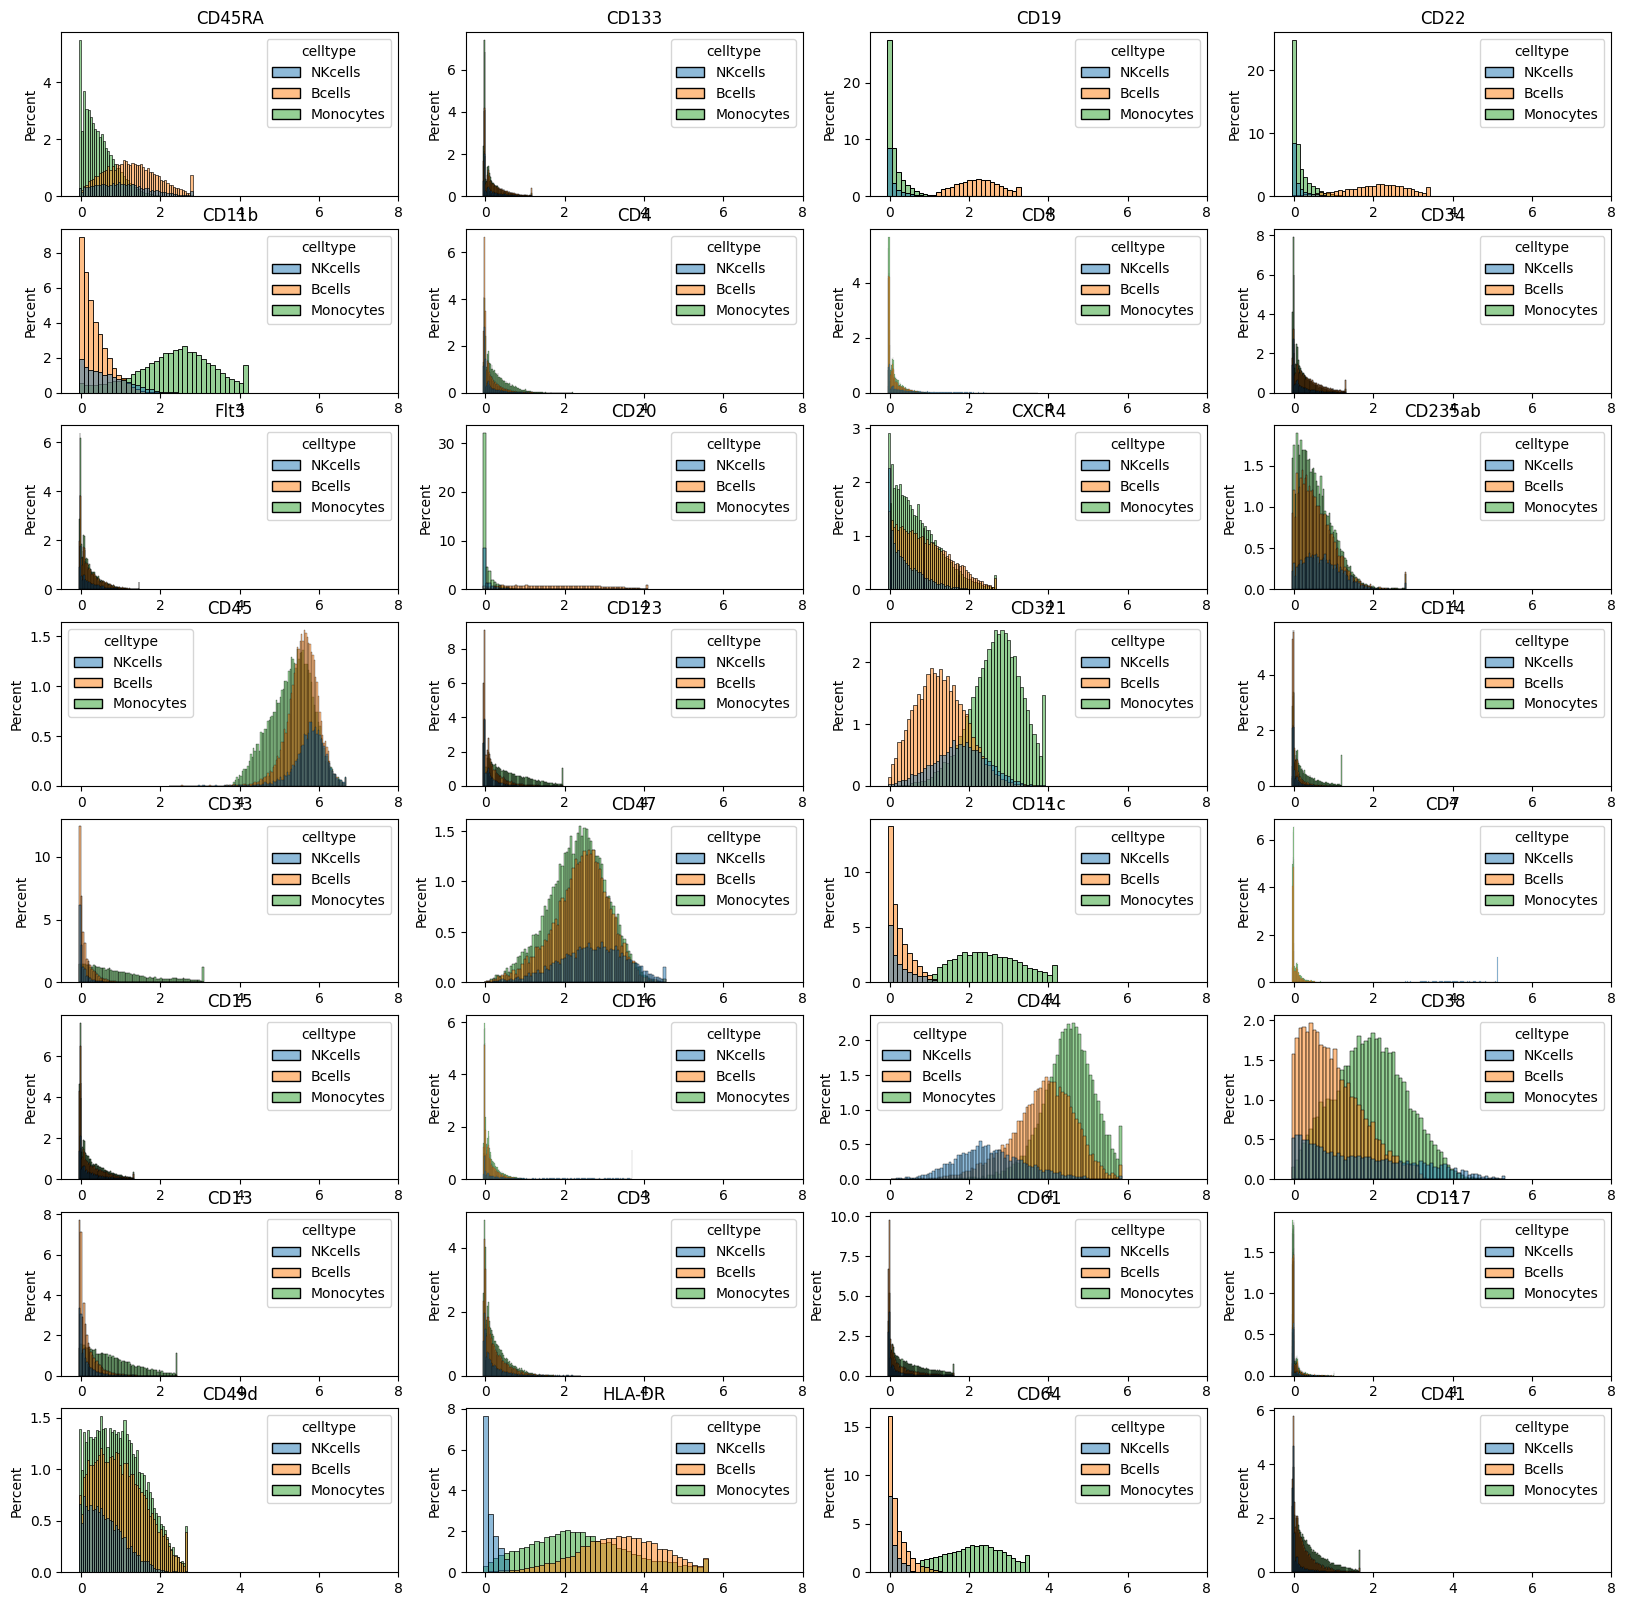

In [11]:
celltypes = ('Monocytes', 'NKcells', 'Bcells')
mask = ad_anno.obs.celltype.isin(celltypes)
df_plot = pd.DataFrame(data=ad_anno[mask, :].layers['arcsinh'], columns=ad_anno.var.marker)
df_plot['celltype'] = ad_anno.obs.celltype.values[mask].astype(str)

fig = plt.figure(figsize=(20, 20))
for m in range(0, df_plot.shape[1] - 1):
    plt.subplot(8, 4, m + 1)
    sns.histplot(data=df_plot, x=df_plot.columns[m], hue="celltype", stat='percent')
    plt.title(df_plot.columns[m])
    plt.xlim([-0.5, 8])
    plt.xlabel('')

#plt.savefig('marker_hist_annotated.pdf', dpi=300)
plt.show()

We can also plot a UMAP embedding of the data and color it by cell type of marker intensity:

In [ ]:
import umap as umap

df = pd.DataFrame(ad_anno.layers['arcsinh'], index=ad_anno.obs.celltype, columns=ad_anno.var.marker)
df = df.groupby('celltype').sample(5000)
df = df.sample(frac=1)

Y1 = umap.UMAP(n_neighbors=50, min_dist=0.5, metric='euclidean').fit_transform(df)
Y1 = pd.DataFrame(Y1, index=df.index, columns=['dim' + str(i) for i in range(Y1.shape[1])])

fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x='dim0', y='dim1', hue='celltype', data=Y1, s=2)
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.savefig('umap_celltype.png', dpi=300)
plt.show()

In [ ]:
fig, axs = plt.subplots(8, 4, figsize=(4 * 3, 8 * 3))
for i, ax in zip(df.columns, axs.flat):
    _ = sns.scatterplot(x='dim0', y='dim1', hue=df[i], data=Y1, s=1, ax=ax)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('UMAP_1')
    ax.set_ylabel('UMAP_2')

fig.tight_layout()
fig.savefig('umap_markers.png', dpi=300)
plt.show()

### Train the neural network classifier
As in the standard scQUEST tutorial, we will train a neural network classifier using the annotated data. Here, we adapt the default architecture of `scQUEST.classifier` model so that the input dimensions are 32 (equal to the number of features), the two hidden layers consist of 16 and 8 neurons, respectively, and the output layer consists of 6 neurons, equal to the cell types - classes. All other parameters of the model and training (e.g., activation functions, loss function) are as previously defined in the [standard scQUEST tutorial](https://github.com/AI4SCR/scQUEST/blob/master/tutorials/scQUEST_tutorial.ipynb).

In [14]:
ad_anno.obs['celltype'].value_counts()

CD4Tcells    26366
Monocytes    21099
CD8Tcells    20108
Bcells       16520
NKcells       6153
PreBcells     6135
Name: celltype, dtype: int64

In [13]:
ad_anno.obs['celltype_id'] = ad_anno.obs.groupby('celltype').ngroup()
n_classes = ad_anno.obs.celltype.nunique()
n_features = ad_anno.X.shape[1]
print(f'n_classes: {n_classes}')
print(f'n_features: {n_features}')

from scQUEST.classifier import DefaultCLF, ClfLitModule
import torchmetrics
import torch
from torch import nn

# the line before shows how to customize the model architecture
model = DefaultCLF(n_in=n_features, n_out=n_classes, hidden=(16, 8))
model

n_classes: 6
n_features: 32


DefaultCLF(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=6, bias=True)
  )
)

Since, as we saw in Step 2, the celltype distribution of this dataset is very unbalanced, we split the dataset into training (50%), validation (25%), and test (25%) sets in a **stratified** fashion to preserve cell type proportions, and also use a cross-entropy loss function **with class weights**, defined as the inverse proportions of the classes:

In [15]:
from torch import nn

counts = np.bincount(ad_anno.obs.celltype_id)
weight = 1 / counts
weight = weight / weight.sum()
weight = torch.tensor(weight).float()

loss = nn.CrossEntropyLoss(weight=weight)

mapping = ad_anno.obs[['celltype', 'celltype_id']].set_index('celltype_id').squeeze().to_dict()
df = pd.DataFrame({'counts': counts, 'weight': weight, 'celltype_id': range(len(counts))})
df['celltype'] = df.celltype_id.map(mapping)
df

,counts,weight,celltype_id,celltype
0,16520,0.116161,0,Bcells
1,26366,0.072783,1,CD4Tcells
2,20108,0.095434,2,CD8Tcells
3,21099,0.090951,3,Monocytes
4,6153,0.311878,4,NKcells
5,6135,0.312793,5,PreBcells


Let's train the model using again an early stopping criterion:

In [16]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-3, patience=10)

# initialize model and train classifier
clf = scq.Classifier(model=model, loss_fn=loss, seed=1)
clf.fit(ad_anno, layer='arcsinh', target='celltype_id', callbacks=[es], max_epochs=50, seed=2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params
------------------------------------------------------
0 | model            | DefaultCLF       | 718   
1 | loss             | CrossEntropyLoss | 0     
2 | metric_accuracy  | Accuracy         | 0     
3 | metric_f1score   | F1Score          | 0     
4 | metric_precision | Precision        | 0     
5 | metric_recall    | Recall           | 0     
------------------------------------------------------
718       Trainable params
0         Non-trainable params
718       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.003247443586587906
  test_metric_accuracy      0.9994812607765198
   test_metric_f1score      0.9994812607765198
  test_metric_precision     0.9994812607765198
   test_metric_recall       0.9994812607765198
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Exploring the model's performance as before (e.g., plotting the loss and the confusion matrix), we see that it achieves a 99.9% accuracy and 99.9% precision in the test set.

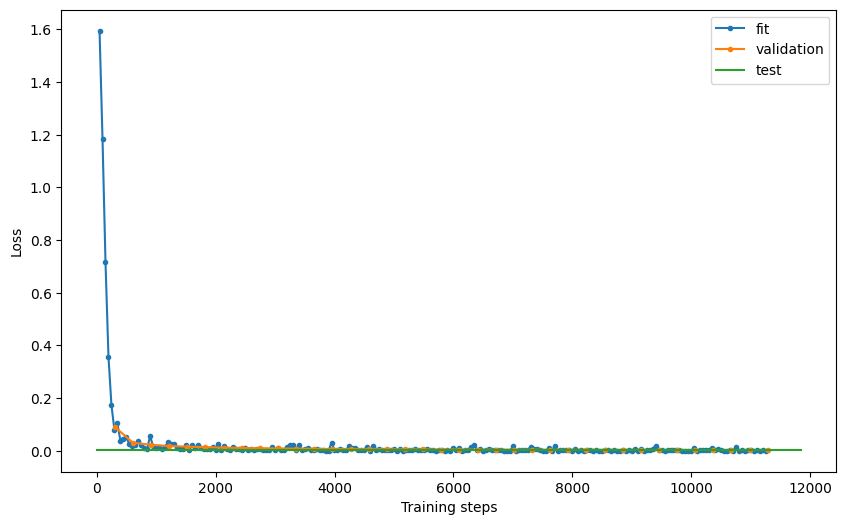

In [13]:
# examine model performance
hist = clf.logger.history
fit_loss = pd.DataFrame.from_records(hist['fit_loss'], columns=['step', 'loss']).assign(stage='fit')
val_loss = pd.DataFrame.from_records(hist['val_loss'], columns=['step', 'loss']).assign(stage='validation')
test_loss = pd.DataFrame.from_records(hist['test_loss'], columns=['step', 'loss']).assign(stage='test')
loss = pd.concat((fit_loss, val_loss, test_loss))
loss = loss.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
for stage in ['fit', 'validation', 'test']:
    if stage == 'test':
        ax.plot([0, ax.get_xlim()[1]], [loss[loss.stage == stage].loss, loss[loss.stage == stage].loss], label='test')
    else:
        ax.plot(loss[loss.stage == stage].step, loss[loss.stage == stage].loss, '.-', label=stage)
plt.xlabel('Training steps')
plt.ylabel('Loss')
ax.legend()
#plt.savefig('loss.pdf', dpi=300)

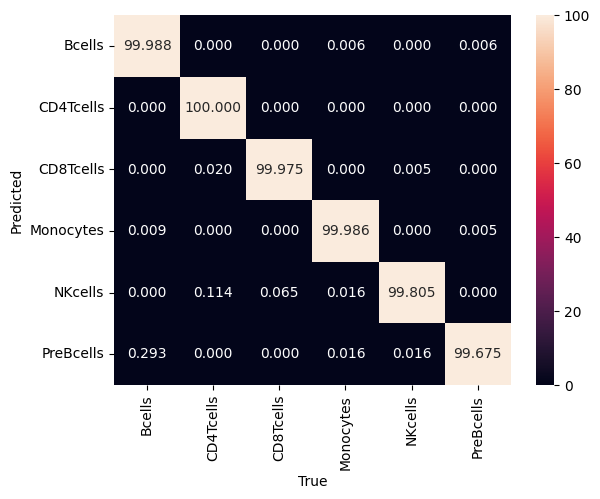

In [14]:
# %% confusion matrix
dl = clf.datamodule.test_dataloader()
data = dl.dataset.dataset.data
y = dl.dataset.dataset.targets
yhat = clf.model(data)

mapping = ad_anno.obs[['celltype', 'celltype_id']].set_index('celltype_id').squeeze().to_dict()
m = confusion_matrix(y, yhat, normalize='pred')
m = pd.DataFrame(m)
m.index = m.index.map(mapping)
m.columns = m.columns.map(mapping)
m.index.name = 'True'
m.columns.name = 'Predicted'
sns.heatmap(m.T * 100, annot=True, fmt='.3f');
#plt.savefig('confusion.pdf', dpi=300)

plt.show()

In [15]:
del ad_anno
del ad

## Step 3: Phenotypic abnormality

We will again follow the same steps as in the [standard scQUEST tutorial](https://github.com/AI4SCR/scQUEST/blob/master/tutorials/scQUEST_tutorial.ipynb) to illustrate how to compute phenotypic abnormlaity. This time, our reference dataset, used to train the Abnormality autoencoder, is the bone marrow data originating from healthy donors, and the query dataset is the bone marrow data originating from AML patients. We first load the AnnData object that contains all measurements, and then preprocess as before.

In [16]:
ad = scq.dataset.aml_and_healthy()
ad.obs.head()

In [18]:
X = ad.X.copy()
quantiles = np.quantile(X, q=.995, axis=0)
for i, thres in zip(range(X.shape[1]), quantiles):
    X[X[:, i] > thres, i] = thres
cofactor = 5
np.divide(X, cofactor, out=X)
np.arcsinh(X, out=X)
ad.layers['arcsinh'] = X

Next, subset the whole dataset to only include cells from the selected healty patients, and scale the data as before:

In [19]:
ad_train = ad[ad.obs.tissue == 'healthy', ad.var.usedforPhenoGraphclustering == 'yes']

n_features = ad_train.X.shape[1]
print(f'n_cells: {len(ad_train)}')
print(f'n_features: {n_features}')

scaler = MinMaxScaler()
X = scaler.fit_transform(ad_train.layers['arcsinh'])
ad_train.layers['arcsinh_norm'] = X

assert np.isclose(ad_train.layers['arcsinh_norm'].max(), 1)
assert np.isclose(ad_train.layers['arcsinh_norm'].min(), 0)

n_cells: 183414
n_features: 30


### Train the abnormality Autoencoder

We follow the same process as before, but note how we customize the dimensions of the autoencoder:

In [21]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from scQUEST.abnormality import DefaultAE
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-3, patience=10)

model = DefaultAE(n_in=n_features, hidden=(16, 8, 4, 8, 16))
model

DefaultAE(
  (activation): ReLU()
  (activation_last): Sigmoid()
  (layers): ModuleList(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=8, bias=True)
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=30, bias=True)
  )
)

In [22]:
# Initialize and fit the model
Abn = scq.Abnormality(model=model)
Abn.fit(ad_train, layer='arcsinh_norm', callbacks=[es], max_epochs=20)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                    | Type             | Params
-------------------------------------------------------------
0 | model                   | DefaultAE        | 1.4 K 
1 | loss                    | MSELoss          | 0     
2 | metric_meansquarederror | MeanSquaredError | 0     
-------------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric                 DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_loss              0.013673492707312107
test_metric_meansquarederror    0.013673494569957256
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


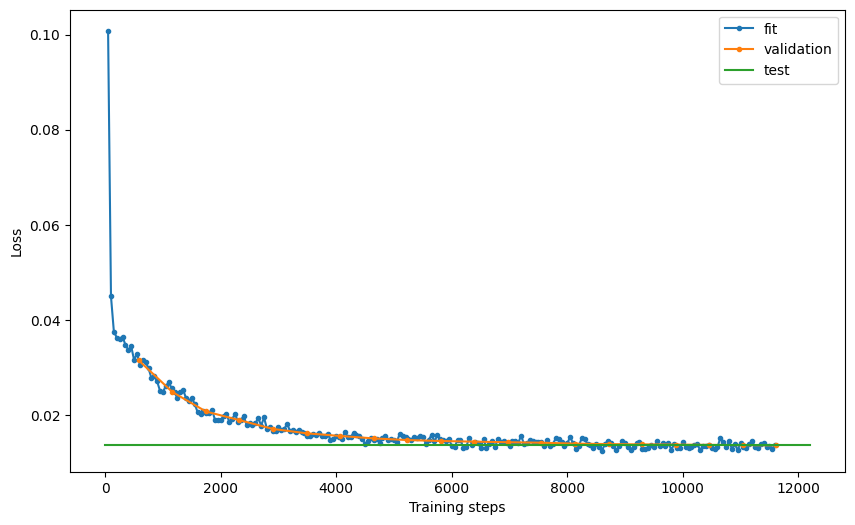

In [23]:
# examine model performance
hist = Abn.logger.history
fit_loss = pd.DataFrame.from_records(hist['fit_loss'], columns=['step', 'loss']).assign(stage='fit')
val_loss = pd.DataFrame.from_records(hist['val_loss'], columns=['step', 'loss']).assign(stage='validation')
test_loss = pd.DataFrame.from_records(hist['test_loss'], columns=['step', 'loss']).assign(stage='test')
loss = pd.concat((fit_loss, val_loss, test_loss))
loss = loss.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
for stage in ['fit', 'validation', 'test']:
    if stage == 'test':
        ax.plot([0, ax.get_xlim()[1]], [loss[loss.stage == stage].loss, loss[loss.stage == stage].loss], label='test')
    else:
        ax.plot(loss[loss.stage == stage].step, loss[loss.stage == stage].loss, '.-', label=stage)
plt.xlabel('Training steps')
plt.ylabel('Loss')
ax.legend()
#plt.savefig('loss.pdf', dpi=300)

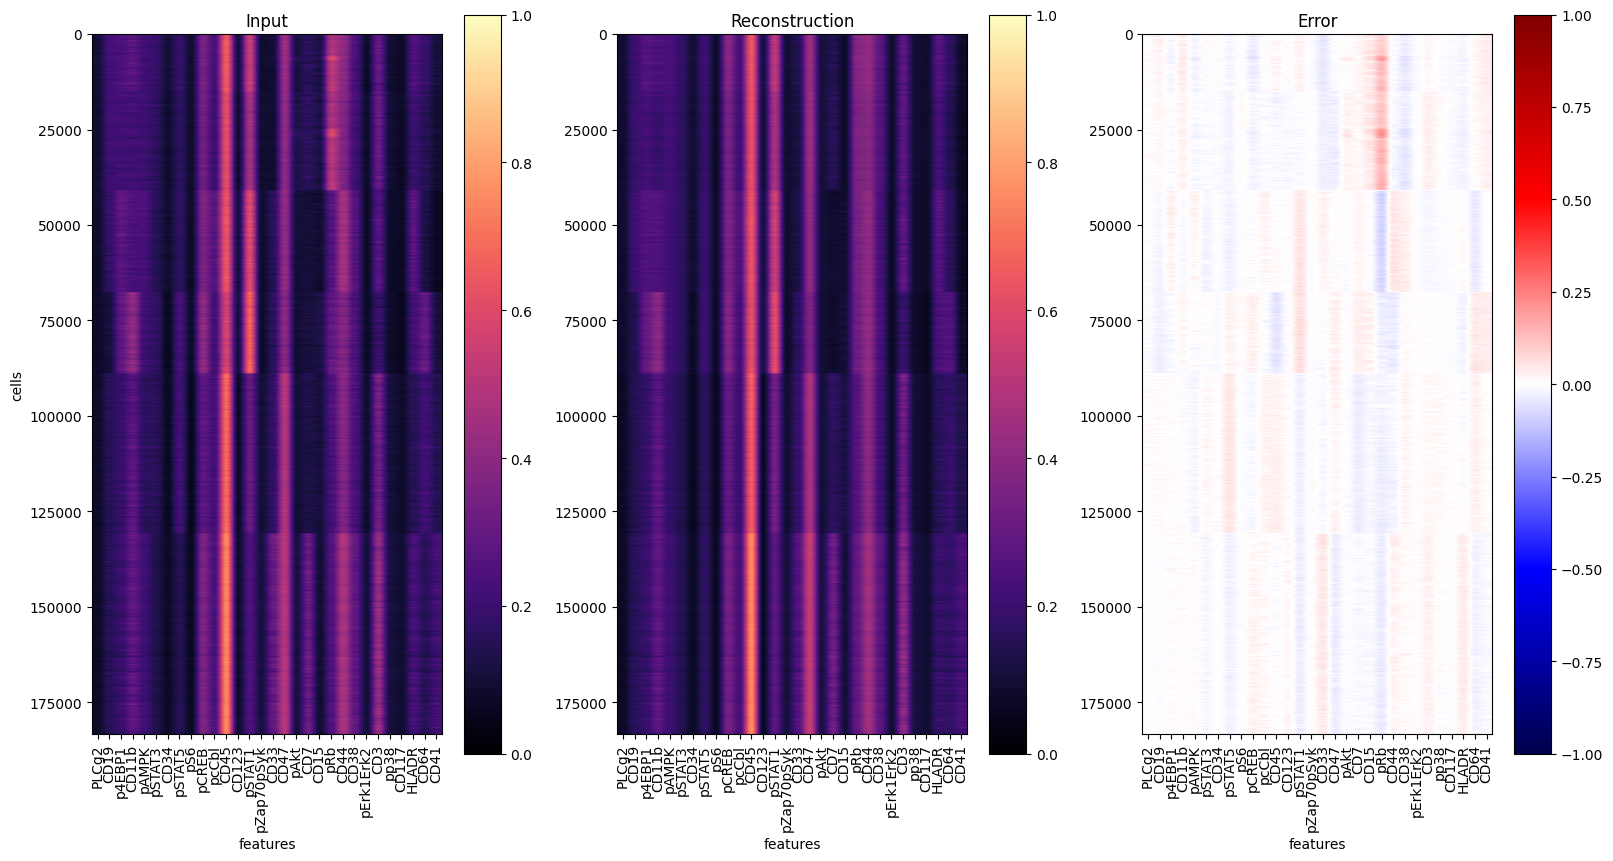

In [24]:
# estimate reconstruction error on the training data
Abn.predict(ad_train, layer='arcsinh_norm')
mse_train = (ad_train.layers['abnormality'] ** 2).mean(axis=1)
ad_train.obs['abnormality'] = mse_train

y = ad_train.layers['arcsinh_norm']
yhat = Abn.model.model(torch.tensor(y)).detach().numpy()  # access base torch model
err = ad_train.layers['abnormality']

markers = ad_train.var['marker'].values
fig, axs = plt.subplots(1, 3, figsize=(16 * 1.2, 8 * 1.2))
for ax, dat, title in zip(axs.flat, [y, yhat, err], ['Input', 'Reconstruction', 'Error']):
    ax: plt.Axes
    cmap = 'seismic' if title == 'Error' else 'magma'
    vmin = -1 if title == 'Error' else 0
    im = ax.imshow(dat, cmap=cmap, vmin=vmin, vmax=1)
    ax.set_aspect(dat.shape[1] * 2 / dat.shape[0])
    ax.set_xticks(range(len(markers)), labels=markers, rotation='vertical')
    ax.set_xlabel('features')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
axs[0].set_ylabel('cells')
fig.show()

In [25]:
del ad_train

Now let's use the model to reconstruct all cells and compute the mean squared error of the reconstruction: 

In [27]:
# pre-process for Abnormality prediction
ad_pred = ad[:, ad.var.usedforPhenoGraphclustering == 'yes']
X = scaler.transform(ad_pred.layers['arcsinh'])
ad_pred.layers['arcsinh_norm'] = X

# estimate reconstruction error
Abn.predict(ad_pred, layer='arcsinh_norm')
mse = (ad_pred.layers['abnormality'] ** 2).mean(axis=1)
ad_pred.obs['abnormality'] = mse

To evaluate the results, let's reconstruct all single-cells and visualize the prediction residuals:

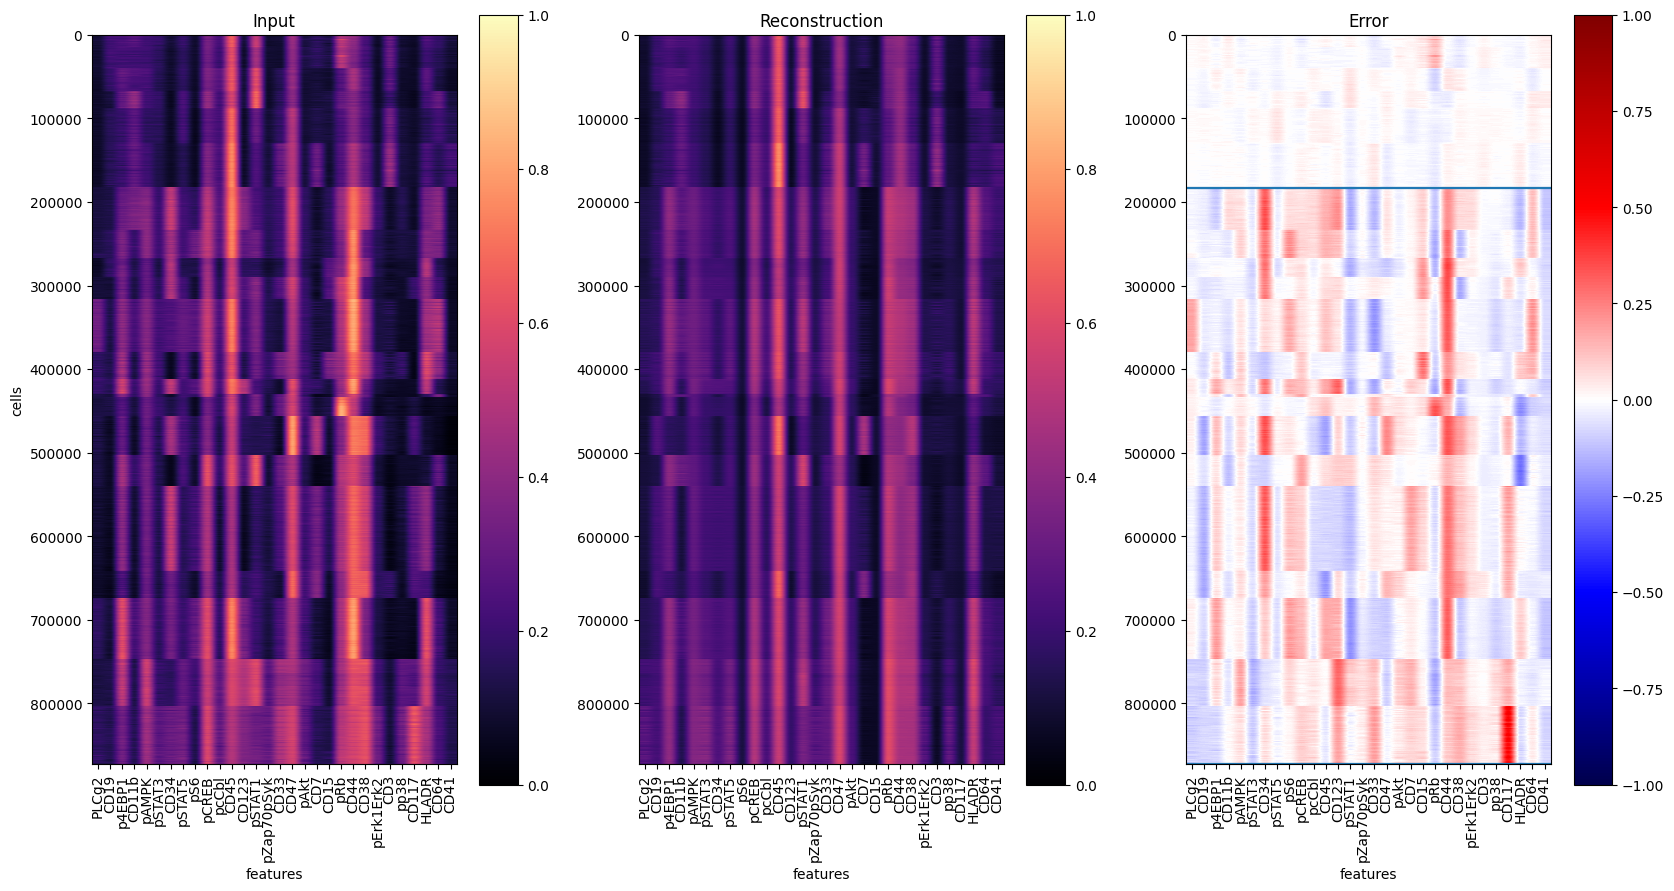

In [28]:
y = ad_pred.layers['arcsinh_norm']
yhat = Abn.model.model(torch.tensor(y)).detach().numpy()  # access base torch model
err = ad_pred.layers['abnormality']
y1 = ad_pred.obs[ad_pred.obs['tissue'] == 'healthy'].shape[0]
y2 = ad_pred.obs[ad_pred.obs['tissue'] == 'AML'].shape[0]

markers = ad_pred.var['marker'].values
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for ax, dat, title in zip(axs.flat, [y, yhat, err], ['Input', 'Reconstruction', 'Error']):
    ax: plt.Axes
    cmap = 'seismic' if title == 'Error' else 'magma'
    vmin = -1 if title == 'Error' else 0
    im = ax.imshow(dat, cmap=cmap, vmin=vmin, vmax=1)
    plt.hlines(y1, -0.5, len(markers) - 0.5)
    plt.hlines(y1 + y2, -0.5, len(markers) - 0.5)
    ax.set_aspect(dat.shape[1] * 2 / dat.shape[0])
    ax.set_xticks(range(len(markers)), labels=markers, rotation='vertical')
    ax.set_xlabel('features')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
axs[0].set_ylabel('cells')
#plt.savefig('reconstruction.pdf', dpi=300)
fig.show()

Now let's visualize the abnormality for different clinical data: 

<AxesSubplot:xlabel='tissue', ylabel='abnormality'>

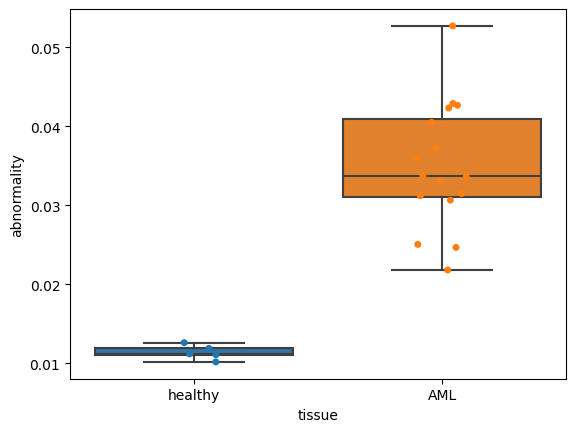

In [29]:
clinical_data = 'tissue'
order = ['healthy', 'AML']

fig, ax = plt.subplots()
dat = ad_pred.obs.groupby([clinical_data, 'patient']).abnormality.agg(
    np.median).dropna().reset_index()
sns.boxplot(data=dat, x=clinical_data, y='abnormality', order=order, whis=[0, 100], ax=ax)
sns.stripplot(data=dat, x=clinical_data, y='abnormality', order=order, ax=ax)
#plt.savefig('abnormality_boxplots.pdf', dpi=300)

## Tumor individuality

The tumor individuality module for the AML dataset is largely unchanged from the default scQUEST tutorial. We first prepare the dataset and randomly select a subset of cells from each sample: 

In [30]:
# preprocessing
ad.obs['sample_id'] = ad.obs.groupby(['tissue', 'patient']).ngroup()

# sub-sampling
tmp = ad.obs.groupby(['sample_id']).indices
n_cells = 200
indices = []
for key, item in tmp.items():
    size = min(len(item), n_cells)
    idx = np.random.choice(range(len(item)), size, replace=False)
    indices.extend(item[idx])
indices = np.array(indices)
ad = ad[indices]

We initialize the individuality model and use it to predict the scores:

In [31]:
Indiv = scq.Individuality()
Indiv.predict(ad, ad.obs.sample_id, layer='arcsinh')

The observation-level scores (one vector per single cell, indicating it's similarity to all other samples) are saved in the `.obsm` attribute of the AnnData object, as a matrix of size `n_cells x n_samples`:

In [32]:
ad.obsm['individuality']

matrix([[0.63, 0.29, 0.  , ..., 0.  , 0.01, 0.  ],
        [0.44, 0.08, 0.19, ..., 0.  , 0.  , 0.  ],
        [0.82, 0.18, 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.03, 0.04, 0.04, ..., 0.01, 0.12, 0.4 ],
        [0.  , 0.  , 0.01, ..., 0.  , 0.31, 0.57],
        [0.01, 0.  , 0.05, ..., 0.  , 0.07, 0.45]])

The aggregated sample-level scores (one vector per sample, indicating a sample's similarity to all other samples) are saved in the .uns attribute of the AnnData object, as a matrix of size `n_samples x n_samples`:

In [33]:
# access sample-level aggregated individuality
ad.uns['individuality_agg'].head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.55865,0.2529,0.02360,0.00000,0.00000,0.00670,0.00085,0.00005,0.00490,0.00505,...,0.00070,0.00920,0.05935,0.00765,0.00825,0.00075,0.00380,0.0002,0.00870,0.01705
1,0.34195,0.4059,0.03155,0.00000,0.00000,0.00865,0.00030,0.00000,0.01510,0.00505,...,0.00065,0.01015,0.08965,0.00795,0.00500,0.00160,0.00370,0.0007,0.00880,0.02500
2,0.02330,0.0172,0.43995,0.00000,0.00000,0.08260,0.00010,0.00000,0.03135,0.03415,...,0.06670,0.06990,0.07185,0.00015,0.01865,0.00580,0.01390,0.0012,0.02645,0.04250
3,0.00000,0.0000,0.00005,0.63685,0.32990,0.00570,0.00000,0.00050,0.00000,0.00025,...,0.00195,0.00020,0.00000,0.00000,0.00020,0.01590,0.00115,0.0001,0.00560,0.00165
4,0.00000,0.0000,0.00005,0.26960,0.68605,0.00805,0.00000,0.00105,0.00000,0.00050,...,0.00220,0.00070,0.00000,0.00000,0.00015,0.01710,0.00145,0.0003,0.00755,0.00525


To assess a sample's uniqueness withn the cohort, we will use the diagonal of that matrix:

In [34]:
dat = ad.uns['individuality_agg'].copy()
dat = pd.DataFrame(np.diag(dat), index=dat.index, columns=['individuality'])

Now let's assess how individuality scores are related to a patient's clinical data:

<AxesSubplot:xlabel='tissue', ylabel='individuality'>

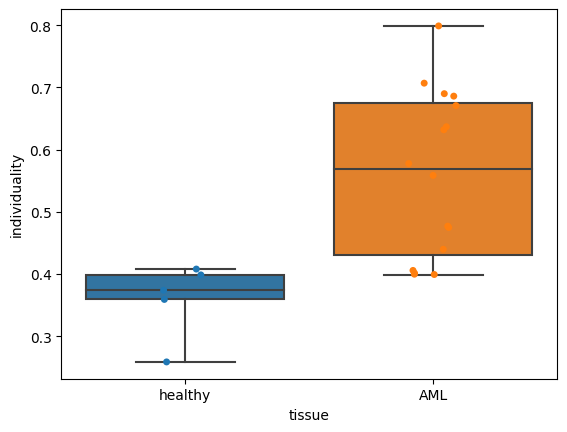

In [35]:
res = ad.obs[['tissue', 'patient', 'sample_id']]
res = res[~res.duplicated()].set_index('sample_id')
dat = pd.concat((dat, res), axis=1)

clinical_data = 'tissue'
order = ['healthy', 'AML']

fig, ax = plt.subplots()
sns.boxplot(data=dat, x=clinical_data, y='individuality', order=order, whis=[0, 100], ax=ax)
sns.stripplot(data=dat, x=clinical_data, y='individuality', order=order, ax=ax)
#plt.savefig('individuality_boxplots.pdf', dpi=300)